Sequence to Sequence Models
=============================

## Download Plotting and Helper Functions

Download the followings files and place them in the same folder as the notebook before proceed further. These files contain the utility functions and plotting functions needed for this notebook. 

In [28]:
from IPython.display import FileLink, FileLinks

In [29]:
FileLink('plots.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\plots.py

In [30]:
FileLink('plots_seq2seq.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\plots_seq2seq.py

In [31]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\util.py

In [32]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\LSTM\replay.py

## Imports

In [33]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from util import StepByStep
from plots import *
from plots_seq2seq import *

## Data Generation

In [2]:
def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

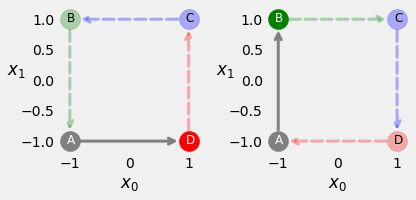

In [3]:
fig = counter_vs_clock(binary=False)

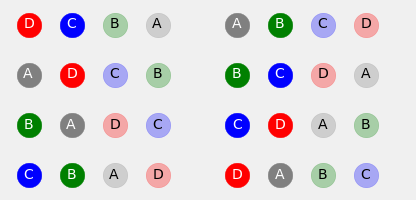

In [4]:
fig = plot_sequences(binary=False, target_len=2)

In [5]:
points, directions = generate_sequences(n=128, seed=13)

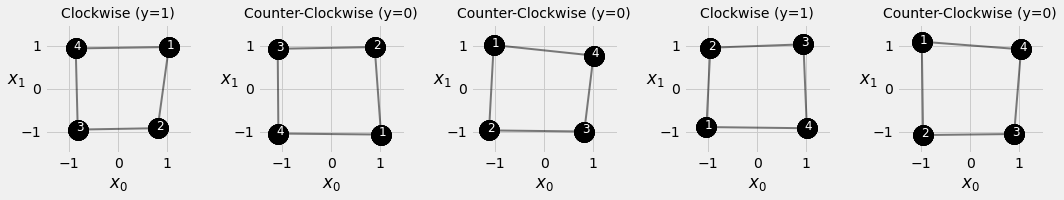

In [6]:
fig = plot_data(points, directions, n_rows=1)

## Encoder-Decoder Architecture

### Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
                
    def forward(self, X):        
        rnn_out, self.hidden = self.basic_rnn(X)
        
        return rnn_out # N, L, F

In [8]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2] # first two corners
target_seq = full_seq[:, 2:] # last two corners

In [9]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq) # output is N, L, F
hidden_final = hidden_seq[:, -1:]   # takes last hidden state
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward>)

### Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True) 
        self.regression = nn.Linear(self.hidden_dim, self.n_features)
        
    def init_hidden(self, hidden_seq):
        # We only need the final hidden state
        hidden_final = hidden_seq[:, -1:] # N, 1, H
        # But we need to make it sequence-first
        self.hidden = hidden_final.permute(1, 0, 2) # 1, N, H                      
        
    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden) 
        
        last_output = batch_first_output[:, -1:]
        out = self.regression(last_output)
        
        # N, 1, F
        return out.view(-1, 1, self.n_features)               

In [11]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)   # Predicts coordinates
    print(f'Output: {out}\n')
    # Predicted coordinates are next step's inputs
    inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward>)



#### Teacher Forcing

In [12]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates    
    print(f'Output: {out}\n')
    # But completely ignores the predictions and uses real data instead
    inputs = target_seq[:, i:i+1]

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Output: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward>)



In [13]:
# Initial hidden state is encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)
    print(f'Output: {out}\n')
    # If it is teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        # Takes the actual element
        inputs = target_seq[:, i:i+1]
    else:
        # Otherwise uses the last predicted output
        inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward>)



### Encoder + Decoder

![](images/encoder_decoder.png)

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None
        
    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size, 
                              self.target_len, 
                              self.encoder.n_features).to(device)
    
    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        
    def forward(self, X):               
        # splits the data in source and target sequences
        # the target seq will be empty in testing mode
        # N, L, F
        source_seq = X[:, :self.input_len, :]
        target_seq = X[:, self.input_len:, :]
        self.init_outputs(X.shape[0])        
        
        # Encoder expected N, L, F
        hidden_seq = self.encoder(source_seq)
        # Output is N, L, H
        self.decoder.init_hidden(hidden_seq)
        
        # The last input of the encoder is also
        # the first input of the decoder
        dec_inputs = source_seq[:, -1:, :]
        
        # Generates as many outputs as the target length
        for i in range(self.target_len):
            # Output of decoder is N, 1, F
            out = self.decoder(dec_inputs)
            self.store_output(i, out)
            
            prob = self.teacher_forcing_prob
            # In evaluation/test the target sequence is
            # unknown, so we cannot use teacher forcing
            if not self.training:
                prob = 0
                
            # If it is teacher forcing
            if torch.rand(1) <= prob:
                # Takes the actual element
                dec_inputs = target_seq[:, i:i+1, :]
            else:
                # Otherwise uses the last predicted output
                dec_inputs = out
            
        return self.outputs

In [15]:
encdec = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=1.0)

In [16]:
encdec.train()
encdec(full_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.2265,  0.4529]]], grad_fn=<CopySlices>)

In [17]:
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [-0.0226,  0.4628]]], grad_fn=<CopySlices>)

### Data Preparation

In [18]:
points, directions = generate_sequences()
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

In [19]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [20]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Training & Configuration

In [21]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

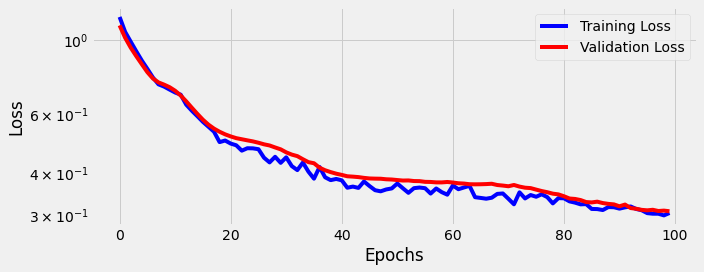

In [23]:
fig = sbs_seq.plot_losses()

### Visualizing Predictions

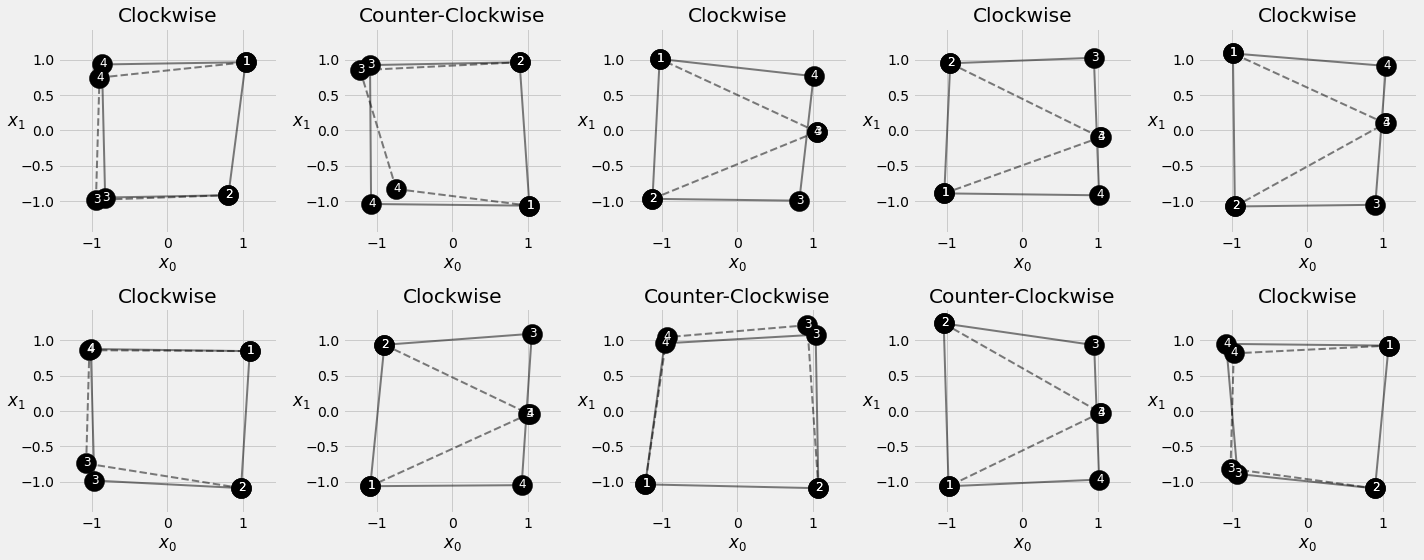

In [24]:
fig = sequence_pred(sbs_seq, full_test, test_directions)